# Loan Approval Binary Classification Model

>The goal of my project is to predict whether or not someone will be approved for a home or auto loan based on a number of factors. This is a binary classification problem as the loan applicants will be sorted into two groups, either accepted or denied. I will be using logistic regression and random forests to complete this task.
>
>The github link: https://github.com/joja4479/DTSA-5509-Final-Project/

## The Data


>I am using the following dataset from Kaggle [Link to dataset](https://www.kaggle.com/datasets/deboleenamukherjee/financial-risk-data-large) 
>
> The dataset contains 51 columns and 1,000,000 rows of data. Each row corresponds to an individual who applied for a loan. The columns include various risk factors that a lender would take into account when assessing whether or not to approve the individual for the loan, such as: income, outstanding debts, credit scores, education level, etc. It also includes a column that represents our target variable "LoanApproved". 1=Approved 0=Denied
>
>The dataset contains data for various types of loans, but I will be focusing on 2 subsets, auto and home loans.

In [2]:
from math import exp
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image

from statsmodels.api import OLS


## Import The Data
> Read in the financial risk dataset csv file and split it into two dataframes.
> 
> One dataframe will contain all of the rows for auto loans
>
> The second dataframe will contain all rows corresponding to home loans

In [3]:
csv_url = 'financial_risk_analysis_large.csv'

df = pd.read_csv(csv_url)

df_auto = df[df.LoanPurpose == 'Auto']
df_home = df[df.LoanPurpose == 'Home']

df_auto.head()

,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,EmploymentStatus,MaritalStatus,NumberOfDependents,EducationLevel,HomeOwnershipStatus,...,JobTenure,MonthlySavings,AnnualBonuses,AnnualExpenses,MonthlyHousingCosts,MonthlyTransportationCosts,MonthlyFoodCosts,MonthlyHealthcareCosts,MonthlyEntertainmentCosts,LoanApproved
7,766,69614,15391,16,34,Employed,Divorced,3,Associate,Rent,...,26,-130,6223,34655,510,560,459,264,265,0
16,643,68970,21560,10,56,Employed,Divorced,0,High School,Other,...,32,129,3963,28025,1559,447,492,216,76,1
21,576,44619,26103,22,26,Unemployed,Single,3,Associate,Own,...,18,863,2653,25626,1577,228,442,183,48,1
22,460,61995,25803,1,19,Unemployed,Divorced,0,Bachelor,Own,...,17,878,5608,13691,919,236,570,272,79,0
29,810,61051,22972,3,20,Self-Employed,Married,4,Doctorate,Own,...,22,438,5776,26674,1278,625,200,214,58,0


## Clean the data

>There are 51 columns in the dataset and many of them will not be needed for our models. After dropping the unneccessary columns, we will also remove any rows that have non-numeric values.

In [4]:
#drop all coulumns that we don't need from each dataframe
df_auto = df_auto.drop(["EmploymentStatus", "MaritalStatus", "EducationLevel","HomeOwnershipStatus", 
              "MonthlyEntertainmentCosts", "MonthlyHealthcareCosts", "MonthlyTransportationCosts",
             "HomeInsuranceStatus", "EmployerType", "OtherInsurancePolicies", "AnnualBonuses",
             "LifeInsuranceStatus", "CarInsuranceStatus", "HealthInsuranceStatus", "LoanPurpose"] , axis=1)

df_home = df_home.drop(["EmploymentStatus", "MaritalStatus", "EducationLevel","HomeOwnershipStatus", 
              "MonthlyEntertainmentCosts", "MonthlyHealthcareCosts", "MonthlyTransportationCosts",
             "HomeInsuranceStatus", "EmployerType", "OtherInsurancePolicies", "AnnualBonuses",
             "LifeInsuranceStatus", "CarInsuranceStatus", "HealthInsuranceStatus", "LoanPurpose"] , axis=1)

#remove any non-numeric values from the dataframes
#convert all non-numeric to NaN and then drop any rows with NaN values
for col in df_auto.columns.values:
    df_auto[col] = pd.to_numeric(df_auto[col], errors="coerce")
    df_home[col] = pd.to_numeric(df_home[col], errors="coerce")
    # Drop rows containing NaN in the current column
    df_auto.dropna(subset=[col], inplace=True)
    df_home.dropna(subset=[col], inplace=True)

## Define Financial Risk Data Class

>The FR_data class takes a dataframe as a parameter and splits the data, then converts the training and test data into arrays. We will call this function twice, once for our auto loan data and once for the home loan data.

In [5]:
class FR_data:
    def __init__(self, df):

        #create our x and y. y is the target variable
        self.x = df.drop(['LoanApproved'], axis=1)
        self.y = df['LoanApproved']

        # split the data into train and test sets
        self.x_train = None 
        self.x_test = None 
        self.y_train = None 
        self.y_test = None
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, random_state=5,test_size=0.25)

        #convert the train and test sets into arrays
        self.x_train = self.x_train.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.x_test = self.x_test.to_numpy()
        self.y_test = self.y_test.to_numpy()
        
data_auto = FR_data(df_auto)
data_home = FR_data(df_home)


## Check for correlations

>Next we want to check for correlations in the data to eliminate any multicollinearity. Fortunately, from looking at df_auto.corr() we can see that no two variables have high correlation with one another. We can see that the highest correlation with our target variable 'LoanApproved' is the variable 'CreditScore'. This makes sense as the purpose of credit score is to show potential lenders how safe it is to lend money to an individual.

In [6]:
#show the correlation matrix for all variables
df_auto.corr()

,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,AutoLoanBalance,PersonalLoanBalance,StudentLoanBalance,UtilityBillsPaymentHistory,JobTenure,MonthlySavings,AnnualExpenses,MonthlyHousingCosts,MonthlyFoodCosts,LoanApproved
CreditScore,1.000000,0.000563,-0.000031,-0.000359,0.002620,0.002695,-0.002532,-0.002653,0.002691,0.000627,...,0.001578,-0.000565,0.002080,0.003627,0.001074,-0.000599,-0.000697,-0.001225,-0.001260,0.488676
AnnualIncome,0.000563,1.000000,-0.000013,-0.001691,-0.000161,0.000893,0.001732,-0.003644,0.002404,0.000391,...,0.002104,0.003443,-0.002387,0.003287,-0.004077,-0.002249,-0.006251,-0.001247,0.001557,0.043056
LoanAmount,-0.000031,-0.000013,1.000000,0.001566,0.000916,0.001785,0.005402,-0.000083,-0.000231,-0.008810,...,0.000989,-0.003695,0.000226,0.000500,0.001383,-0.000414,0.000876,0.001168,0.002878,0.000642
LoanDuration,-0.000359,-0.001691,0.001566,1.000000,0.004326,0.001192,0.002302,0.001209,0.002296,-0.000249,...,0.004489,0.001393,0.001117,0.004483,0.001547,0.000959,0.003001,-0.003263,0.000016,-0.002400
Age,0.002620,-0.000161,0.000916,0.004326,1.000000,0.001506,0.001101,-0.000935,0.002802,0.002523,...,-0.001483,-0.004409,0.000003,-0.001290,-0.002055,0.002165,-0.000027,0.001695,-0.003399,0.000678
NumberOfDependents,0.002695,0.000893,0.001785,0.001192,0.001506,1.000000,0.000550,-0.003469,0.000627,-0.001606,...,-0.002961,-0.000710,0.004628,0.000233,0.005421,-0.002644,0.002017,-0.002235,-0.000018,0.003465
MonthlyDebtPayments,-0.002532,0.001732,0.005402,0.002302,0.001101,0.000550,1.000000,0.000400,0.000099,-0.000361,...,-0.001799,0.004233,0.002699,0.001508,-0.001532,0.001751,0.001191,0.001264,0.000867,-0.000784
CreditCardUtilizationRate,-0.002653,-0.003644,-0.000083,0.001209,-0.000935,-0.003469,0.000400,1.000000,-0.000591,-0.001059,...,-0.000415,-0.000294,0.002100,0.000336,-0.002778,-0.004018,-0.001411,-0.003488,-0.001296,-0.000343
NumberOfOpenCreditLines,0.002691,0.002404,-0.000231,0.002296,0.002802,0.000627,0.000099,-0.000591,1.000000,0.001437,...,-0.000749,0.000471,0.000228,0.000422,-0.003915,-0.000452,0.002088,-0.002963,0.000592,0.000833
NumberOfCreditInquiries,0.000627,0.000391,-0.008810,-0.000249,0.002523,-0.001606,-0.000361,-0.001059,0.001437,1.000000,...,-0.000729,-0.002051,-0.001125,-0.004331,0.000804,-0.000742,-0.001211,-0.000990,-0.002899,-0.001291


## More Cleaning of the data

Since the dataset is randomly generated and not real data, I decided to eliminate some of the data that looked extremely out of the ordinary. Lenders will take into account an individuals debt to income ratio before approving them from a loan. Generally you need a DTI of .43 or lower to be approved. For this reason, I am creating a new column called ProjectedDTI that will take the monthly payment for the new loan into account. I am then removing any rows where individuals were approved despite having a ProjectedDTI over .43. I only did this with the Auto loan data to see how it compares with the home loan data when all is said and done.

In [7]:
#defines a function to determine if dti is above or below the threshold
def categorize_dti(dti):
    if dti < .43:
        return 0
    else:
        return 1

#get the monthly payment for the new loan
df_auto['NewLoanPayment'] = df_auto['LoanAmount'] * (df_auto['InterestRate'] / 12) * ((1 + (df_auto['InterestRate'] / 12)) ** (df_auto['LoanDuration'] * 12)) / ((1 + (df_auto['InterestRate'] / 12)) ** ((df_auto['LoanDuration'] * 12) - 1))

#calculate the loan to income ratio
df_auto['LoanToIncomeRatio'] = df_auto['NewLoanPayment'] / (df_auto['AnnualIncome'] / 12)

#create ProjectedDTI column which is DebtToIncomeRatio + LoanToIncomeRatio
df_auto['ProjectedDTI'] = df_auto['LoanToIncomeRatio'] + df_auto['DebtToIncomeRatio']

#categorize each row based on whether or not they meet the .43 threshold
df_auto['DTIAboveFortyThree'] = df_auto['ProjectedDTI'].apply(categorize_dti)

#drop the anomalies
df_auto = df_auto.drop(df_auto[(df_auto['DTIAboveFortyThree'] == 1) & (df_auto['LoanApproved'] == 1)].index)

df_auto[['ProjectedDTI', 'DTIAboveFortyThree', 'LoanApproved', 'NewLoanPayment', 'LoanToIncomeRatio', 'AnnualIncome', 'LoanAmount', 'InterestRate','DebtToIncomeRatio','LoanDuration']].head(20)


,ProjectedDTI,DTIAboveFortyThree,LoanApproved,NewLoanPayment,LoanToIncomeRatio,AnnualIncome,LoanAmount,InterestRate,DebtToIncomeRatio,LoanDuration
7,0.317141,0,0,321.428690,0.055408,69614,15391,0.245584,0.261733,16
16,0.426547,0,1,372.554276,0.064820,68970,21560,0.203894,0.361727,10
22,0.190359,0,0,86.081578,0.016662,61995,25803,0.039901,0.173697,1
29,0.199588,0,0,345.586253,0.067927,61051,22972,0.177889,0.131660,3
35,0.779996,1,0,59.130087,0.009098,77989,19127,0.036983,0.770898,5
45,1.025644,1,0,270.791362,0.041233,78808,17524,0.182651,0.984411,13
69,0.514978,1,0,213.641489,0.042792,59911,21117,0.120200,0.472186,1
70,0.129108,0,0,329.437215,0.055633,71059,23536,0.165679,0.073475,22
80,0.907594,1,0,159.988381,0.022421,85626,25641,0.074413,0.885172,20
90,0.726447,1,0,110.489268,0.028361,46749,21913,0.060204,0.698085,16


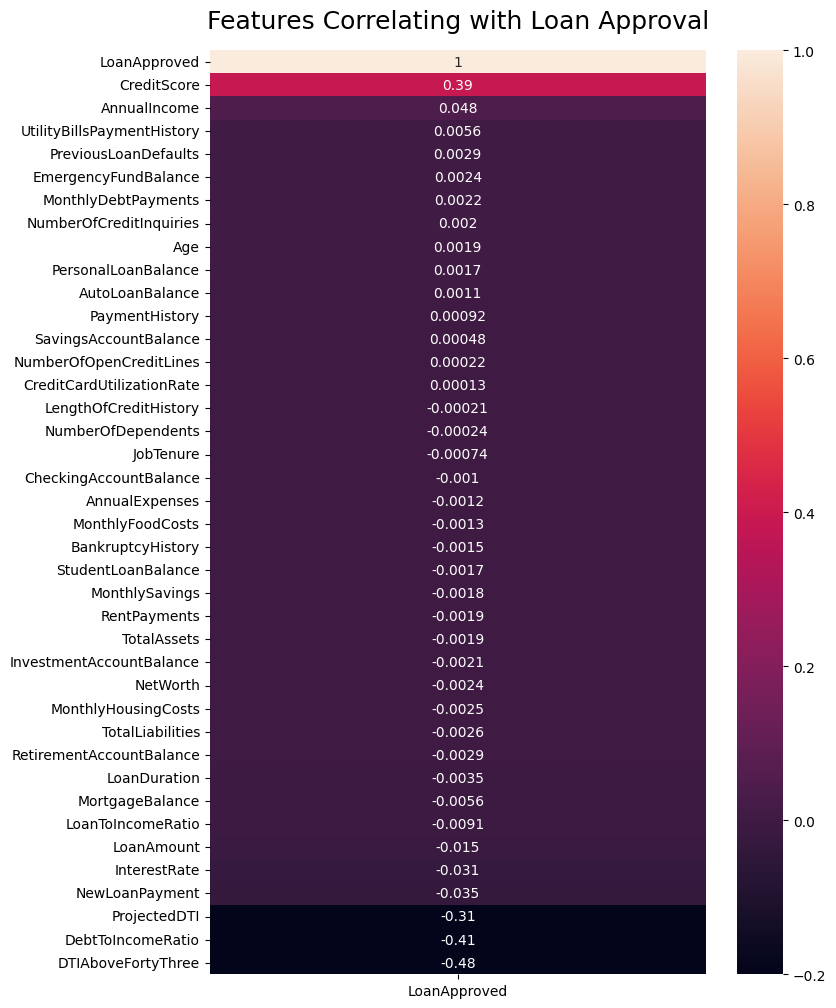

In [8]:
#create a heatmap of all the variables and their correlation with the target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_auto.corr()[['LoanApproved']].sort_values(by='LoanApproved', ascending=False), 
                                    vmin=-.2, vmax=1, annot=True)

heatmap.set_title('Features Correlating with Loan Approval', fontdict={'fontsize':18}, pad=16);

## Scale The Data and Create The Models

>The LogisticRegression method was failing to converge on my initial attempts. There are two options to resolve this, first you can increase the max number of iterations that the LogisticScaling function performs, however this increased the runtime exponentially. The second option is to scale the data which resolved the errors and allowed the below code to run much faster.

In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the features
X_train_scaled_auto = scaler.fit_transform(data_auto.x_train)
X_test_scaled_auto = scaler.fit_transform(data_auto.x_test)

X_train_scaled_home = scaler.fit_transform(data_home.x_train)
X_test_scaled_home = scaler.fit_transform(data_home.x_test)



In [10]:
#create the logistic regression models and fit them to the training data
LogRegAuto = LogisticRegression(random_state = 42, max_iter=10000)

LogRegAuto.fit(X_train_scaled_auto, data_auto.y_train)

auto_y_prediction = LogRegAuto.predict(X_test_scaled_auto)

LogRegHome = LogisticRegression(random_state = 42, max_iter=10000)

LogRegHome.fit(X_train_scaled_home, data_home.y_train)

home_y_prediction = LogRegHome.predict(X_test_scaled_home)

## Checking Accuracy, Recall and Precision

> We can see from the accuracy, recall and precision scores, that the logistic regression models are not great at predicting loan approval from our dataset.

In [29]:
accuracy_home = accuracy_score(data_home.y_test, home_y_prediction)
print("Accuracy:", accuracy_home)

precision_home = precision_score(data_home.y_test, home_y_prediction)
print("Precision:", precision_home)

recall_home = recall_score(data_home.y_test, home_y_prediction)
print("Recall:", recall_home)

Accuracy: 0.6864938281468461
Precision: 0.5968117499552212
Recall: 0.5277997782353873


In [30]:
accuracy_auto = accuracy_score(data_auto.y_test, auto_y_prediction)
print("Accuracy:", accuracy_auto)

precision_auto = precision_score(data_auto.y_test, auto_y_prediction)
print("Precision:", precision_auto)

recall_auto = recall_score(data_auto.y_test, auto_y_prediction)
print("Recall:", recall_auto)

Accuracy: 0.6872765761987498
Precision: 0.596751160299893
Recall: 0.5303262651366929


## Visualizations

> The below code plots the ROC curves of both the auto and home loan models. Below the plots, there are confusion matrices for the 2 models.

Logistic: ROC AUC=0.794


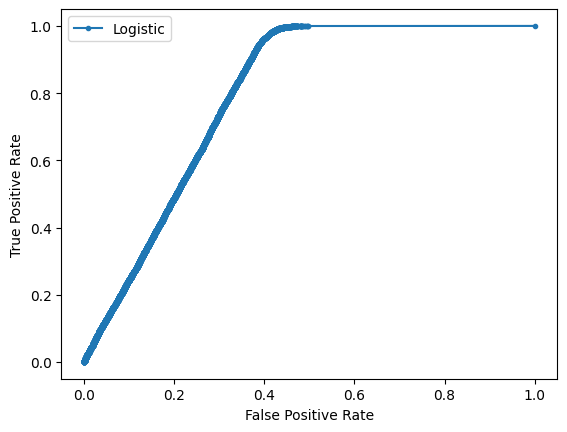

In [15]:
#calculate ROC curve and AUC score then print both
lr_auto = LogRegAuto.predict_proba(X_test_scaled_auto)

lr_auto = lr_auto[:, 1]


auc_auto = roc_auc_score(data_auto.y_test, lr_auto)

print('Logistic: ROC AUC=%.3f' % (auc_auto))

fpr_au, tpr_au, _ = roc_curve(data_auto.y_test, lr_auto)

plt.plot(fpr_au, tpr_au, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

Logistic: ROC AUC=0.792


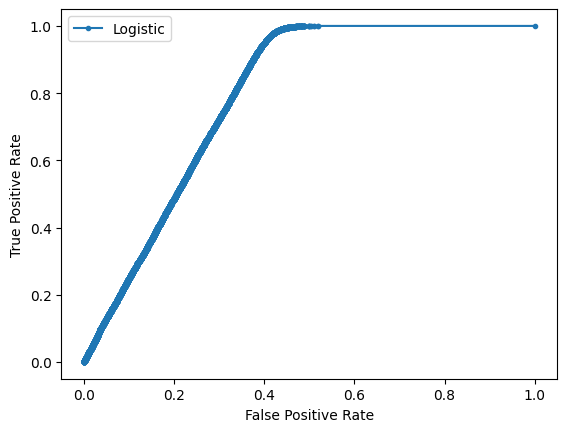

In [16]:
#calculate ROC curve and AUC score then print both
probs_home = LogRegAuto.predict_proba(X_test_scaled_home)

probs_home = probs_home[:, 1]

auc_home = roc_auc_score(data_home.y_test, probs_home)

print('Logistic: ROC AUC=%.3f' % (auc_home))

fpr_hm, tpr_hm, _ = roc_curve(data_home.y_test, probs_home)
plt.plot(fpr_hm, tpr_hm, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

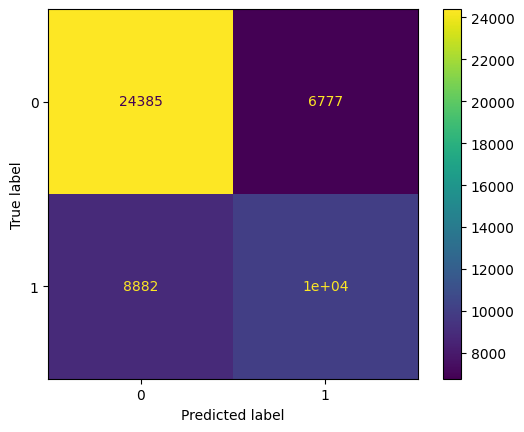

In [17]:
#print the confusion matrix plot
actual = data_auto.y_test
predicted = auto_y_prediction

confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 

cm_display.plot()
plt.show()


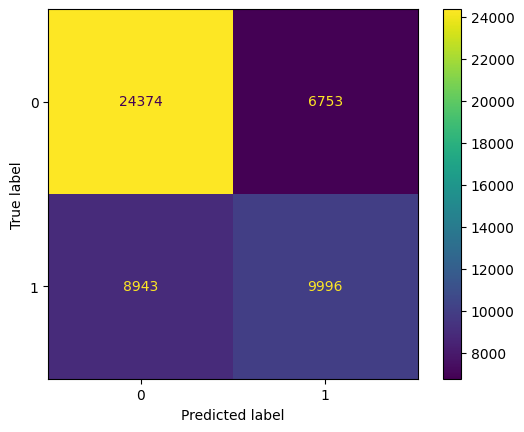

In [18]:
#print the confusion matrix plot
actual = data_home.y_test
predicted = home_y_prediction

confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 

cm_display.plot()
plt.show()

## Hyperparameter Tuning

>Finally I will look at tuning the hyperparameters of the logistic regression model to see if that will improve the accuracy of the models. Logistic regression has 4 different solvers, 'newton-cg', 'lbfgs', 'sag' and 'saga'. The below code will compare the accuracy of the model when each solver is being used. You can also tune the C value, I tried values ranging from .00001 to 100000 and did not find that tuning that parameter made a significant difference when it came to accuracy.

In [19]:
clf = [
    LogisticRegression(solver='newton-cg',penalty='l2', C=1000000, max_iter=1000),
    LogisticRegression(solver='lbfgs',penalty='l2',max_iter=1000),
    LogisticRegression(solver='sag',penalty='l2',max_iter=1000),
    LogisticRegression(solver='saga',penalty='l2',max_iter=1000)
    ]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)

row_index = 0
for alg in clf:
        
    predicted = alg.fit(X_train_scaled_auto, data_auto.y_train).predict(X_test_scaled_auto)
    fp, tp, th = roc_curve(data_auto.y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = alg.score(X_train_scaled_auto, data_auto.y_train)
    clf_compare.loc[row_index, 'Test Accuracy'] = alg.score(X_test_scaled_auto, data_auto.y_test)

    row_index+=1
    
clf_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
clf_compare



,Train Accuracy,Test Accuracy
0,0.688000,0.687317
3,0.687987,0.687297
1,0.687973,0.687277
2,0.687967,0.687277


## Testing out a new model!
### Random Forest Classification

> Since the logistic regression models did OK, but I couldn't improve their accuracy through hyperparameter adjustments. I want to take a look at another binary classification model, random forest classification.

In [20]:
#create random forest classifier and fit it to training data
rf = RandomForestClassifier()
rf.fit(X_train_scaled_home, data_home.y_train)

y_pred_home = rf.predict(X_test_scaled_home)



In [21]:
#create random forest classifier and fit it to training data
rf_auto = RandomForestClassifier()
rf_auto.fit(X_train_scaled_auto, data_auto.y_train)

y_pred_auto = rf_auto.predict(X_test_scaled_auto)

## Checking the accuracy of the new models

> Checking the accuracy and visualizing the confusion matrices of the random forest models

In [22]:
#calculate accuracy, precision and recall scores
accuracy_home = accuracy_score(data_home.y_test, y_pred_home)
print("Accuracy:", accuracy_home)

precision_home = precision_score(data_home.y_test, y_pred_home)
print("Precision:", precision_home)

recall_home = recall_score(data_home.y_test, y_pred_home)
print("Recall:", recall_home)

Accuracy: 0.7436583709503456
Precision: 0.6054440567895264
Recall: 0.9254448492528644


In [23]:
accuracy_auto = accuracy_score(data_auto.y_test, y_pred_auto)
print("Auto Accuracy:", accuracy_auto)

precision_auto = precision_score(data_auto.y_test, y_pred_auto)
print("Precision:", precision_auto)

recall_auto = recall_score(data_auto.y_test, y_pred_auto)
print("Recall:", recall_auto)

Auto Accuracy: 0.7475885207596908
Precision: 0.6087454053679173
Recall: 0.9282957009148115


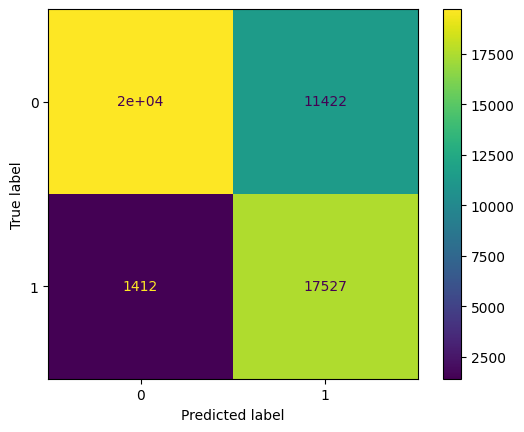

In [24]:
#print the confusion matrix plot
actual = data_home.y_test
predicted = y_pred_home

confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 

cm_display.plot()
plt.show()

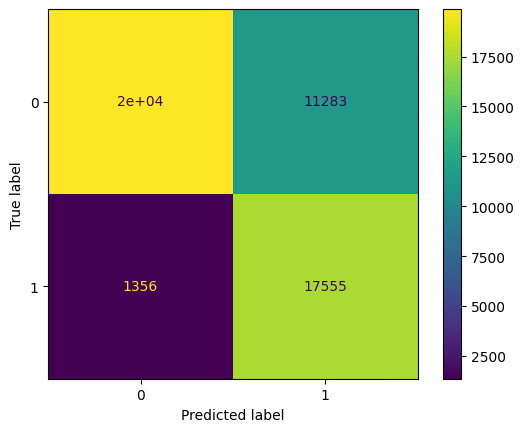

In [25]:
#print the confusion matrix plot
actual = data_auto.y_test
predicted = y_pred_auto

confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 

cm_display.plot()
plt.show()

## Hyperparameter Tuning

> The below code compares various values of max_features and max_depth when creating the random forest classifier model.

In [26]:
#create an array of rf classifiers with different max_depths and max_features
clfs = []
max_depths = [5,6,7,8,9,10,11,12,13,14,15]
max_features = [5,10,15,20]
for max_depth in max_depths:
    for max_feature in max_features:
        clf = RandomForestClassifier(n_estimators = 500, max_depth = max_depth, max_features = max_feature, bootstrap = True, random_state = 18)
        clf.fit(X_train_scaled_home, data_home.y_train)
        clfs.append(clf)



In [27]:
#iterate through the array of classifiers to find the combination of max_features and max_depth that results in the
#highest accuracy and f1 scores
best_clf = clfs[0]
for clf in clfs:
    # Create our predictions
    prediction = clf.predict(X_test_scaled_home)

    max_accuracy = 0
    max_f1 = 0
    acc = accuracy_score(data_home.y_test, prediction)
    rec = recall_score(data_home.y_test, prediction)
    pre = precision_score(data_home.y_test, prediction)
    f1 = f1_score(data_home.y_test, prediction)
    
    if acc > max_accuracy:
        max_accuracy = acc
        best_clf = clf

    if f1 > max_f1:
        max_f1 = f1
        f1_clf = clf

print(best_clf)
print(f1_clf)


    
    #f1_score(data_home.y_test,prediction)

RandomForestClassifier(max_depth=13, max_features=20, n_estimators=500,
                       random_state=18)
RandomForestClassifier(max_depth=13, max_features=20, n_estimators=500,
                       random_state=18)


>Now that we've found a theoretical best classifier, we will fit the new classifier with the ideal hyperparameters and then check the accuracy, precision and recall.

In [28]:
rf_home = RandomForestClassifier(max_depth=13, max_features=20, n_estimators=500,random_state=18)

rf_home.fit(X_train_scaled_home, data_home.y_train)

y_pred_home = rf.predict(X_test_scaled_home)


accuracy_home = accuracy_score(data_home.y_test, y_pred_home)
print("Accuracy:", accuracy_home)

precision_home = precision_score(data_home.y_test, y_pred_home)
print("Precision:", precision_home)

recall_home = recall_score(data_home.y_test, y_pred_home)
print("Recall:", recall_home)

Accuracy: 0.7436583709503456
Precision: 0.6054440567895264
Recall: 0.9254448492528644


## Conclusion


> It was difficult to find a test that had high accuracy for the dataset that I was working with. Logistic regression performed OK, but random forests ended up being a slightly better classifier for this specific dataset. Random forests had high recall scores, but the precision was lagging behind while the accuracy of the model was higher than that of the logistic regression models.
>
> According to the Kaggle page, each field in the dataset is randomly generated so it likely does not compare very well to real-world data. However, it is still a useful dataset for practice. From what I know about home loans, I would have thought DTI would have had a much stronger correlation with the target variable than it did. It does make sense to me that credit score had the strongest correlation to approval, but there are so many factors that lenders consider, so it is not a surprise that it was not strongly correlated. If I were to start this project all over, I would choose a dataset that is more realistic, as the random data proved to be very challenging to get high accuracy scores.
>


